# Import Libraries

In [10]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score,KFold
from data_preprocessing import lemmatize_text_with_pos, tokens,lemmatize_spacy
from sklearn.metrics import classification_report

# Functions/Methods

#### Dataset Function

In [11]:
# Read a single Dataset File
def read_dataset(file_path):
    if file_path.lower().endswith('.csv'):
        dataset = pd.read_csv(file_path)
    elif file_path.lower().endswith('.xlsx'):
        dataset = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")
    
    dataset   = np.array(dataset)
    data_train, data_test     = train_test_split(dataset, test_size=0.2, random_state=100)

    x_train, y_train   = (data_train[:,:-1]), (data_train[:,-1]).astype("int32")
    x_test, y_test     = (data_test[:,:-1]), (data_test[:,-1]).astype("int32")           
    x_train, x_test    = x_train.squeeze(), x_test.squeeze()

    return x_train, x_test, y_train, y_test


# If you have Train and Test Datasets separate
def read_train_test_dataset(train_data, test_data):
    if train_data.lower().endswith('.csv') and test_data.lower().endswith('.csv'):
        train_data = pd.read_csv(train_data)
        test_data = pd.read_csv(test_data)
    elif train_data.lower().endswith('.xlsx') and test_data.lower().endswith('.xlsx'):
        train_data = pd.read_excel(train_data)
        test_data = pd.read_excel(test_data)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")
    
    train_data, test_data   = np.array(train_data), np.array(test_data)

    x_train, y_train   = (train_data[:,:-1]), (train_data[:,-1]).astype("int32")
    x_test, y_test     = (test_data[:,:-1]), (test_data[:,-1]).astype("int32")           
    x_train, x_test    = x_train.squeeze(), x_test.squeeze()

    return x_train, x_test, y_train, y_test

#### Vocabulary Function

In [12]:
def vocab(x):
    all_word = set()
    for i in x:
        all_word.update(tokens(i))
    return all_word

#### Training Function

In [13]:
def naive_bayes_multi(x, y, smoothing=1):
    classes = np.unique(y)
    vocabulary = vocab(x)
    N_doc = x.shape[0]

    log_probs = {}
    ex_dics = {}
    prob_words = {}

    for class_label in classes:
        N_cat = sum(y == class_label)
        examples = " ".join(x[y == class_label])

        log_prob = np.log(N_cat / N_doc)
        log_probs[class_label] = log_prob

        ex_dic = {}
        prob_word = {}

        for word in vocabulary:
            escaped_word = re.escape(word)

            word_count = len(re.findall(escaped_word, examples))
            ex_dic[word] = word_count

            prob_word[word] = np.round(np.log((word_count + smoothing) / (len(tokens(examples)) + len(vocabulary))), 5)

        ex_dics[class_label] = ex_dic
        prob_words[class_label] = prob_word

    # Sort classes to match clf.classes_
    sorted_classes = sorted(classes)

    return log_probs, ex_dics, prob_words, sorted_classes


#### Prediction Function

In [14]:
def predict_naive_bayes(examples, log_probs, prob_words):
    predictions = []

    for example in examples:
        # Tokenize the example
        example_tokens = tokens(example)

        # Calculate the log likelihoods for each class
        class_likelihoods = {}
        for class_label, log_prob in log_probs.items():
            class_likelihood = log_prob + sum(prob_words[class_label].get(word, 0) for word in example_tokens)
            class_likelihoods[class_label] = class_likelihood

        # Make a prediction based on the class with the highest likelihood
        prediction = max(class_likelihoods, key=class_likelihoods.get)
        predictions.append(prediction)

    return predictions

#### Cross Validation

In [15]:
def cross_validation(model_name, x_data, y_data, n_splits=5):
    kf = KFold(n_splits=n_splits)

    fold = 0
    all_predictions = []
    all_labels = []
    all_reports = []

    # Splitting the Data
    for train_index, test_index in kf.split(x_data):
        fold += 1
        print(f"Training fold {fold}/{n_splits}")

        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]

        # Training the Model
        output_dir = f"{model_name}_fold_{fold}"
        log_probs, ex_dics, prob_words, sorted_classes = naive_bayes_multi(x_train, y_train)

        #Evaluate the Model
        predicted_labels = predict_naive_bayes(x_test, log_probs, prob_words)
        report = classification_report(y_test,predicted_labels)
        print(report)

        all_predictions.extend(predicted_labels)
        all_labels.extend(y_test)
        all_reports.append(report)
    return output_dir, all_predictions, all_labels, all_reports

#### Save Reports Function

In [16]:
def save_results(true_label, predicted):
    report_dict = classification_report(true_label,predicted,output_dict=True)

    # Save Result Report
    save_report = pd.DataFrame(report_dict).transpose()  # Convert the report dictionary to a DataFrame
    save_report = save_report.round(3)                   # Round the values to a specific number of decimal places
    save_report = save_report.astype({'support': int})   # Convert the 'support' column to integers
    save_report.loc['accuracy', ['precision', 'recall', 'support']] = [None, None, None] # Set the accuracy row to None

    return save_report

#### Two Model Pipeline

In [17]:
def two_model_pipeline(x_test, log_prob_4class, log_prob_2class, prob_w4, prob_w2):
    #first model predict
    pred1 = predict_naive_bayes(x_test, log_prob_4class, prob_w4)
    pred1_array = np.array(pred1)

    # Identify instances classified as affiliative/aggressive
    aff_agg_mask = (pred1_array == 2)
    # Apply second model only to these instances
    x_test_filtered = [x for x, mask in zip(x_test, aff_agg_mask) if mask]
    print("Length of filtered x_test:", len(x_test_filtered))

    pred2 = predict_naive_bayes(x_test_filtered, log_prob_2class, prob_w2)

    # Combine results
    final_pred = [4 if pred == 3 else pred for pred in pred1]
    pred2 = [2 if p == 0 else 3 for p in pred2]
    
    # Update final_pred with pred2 results
    pred2_index = 0
    for i, mask in enumerate(aff_agg_mask):
        if mask:
            final_pred[i] = pred2[pred2_index]
            pred2_index += 1

    return final_pred, pred2


# Five Class Classification

In [18]:
# Read dataset 
humor_5class_path = "datasets/Humour_style.xlsx" 
x_train_5, x_test_5, y_train_5, y_test_5 = read_dataset(humor_5class_path)

# Lemmmatize (Spacy)
x_train_5 = [' '.join(lemmatize_spacy(example)) for example in x_train_5]
x_test_5  = [' '.join(lemmatize_spacy(example)) for example in x_test_5]

# Convert to numpy array
x_train_5, x_test_5 = np.array(x_train_5), np.array(x_test_5)

# Cross validation
output_dir5, all_predictions5, all_labels5, all_reports5 = cross_validation("5_Classes",x_train_5,y_train_5)
aggregated_reports5 = classification_report(all_labels5,all_predictions5)
print(aggregated_reports5)

# Save Aggregated Cross Validation Results
cross_v_5= save_results(all_labels5,all_predictions5)
cross_v_5.to_csv('cross_validation_results/Naive_Bayes_5classes.csv', index=False)

Training fold 1/5
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        56
           1       0.42      0.68      0.52        34
           2       0.45      0.32      0.37        41
           3       0.51      0.70      0.59        57
           4       1.00      0.50      0.67        46

    accuracy                           0.58       234
   macro avg       0.63      0.57      0.57       234
weighted avg       0.64      0.58      0.58       234

Training fold 2/5
              precision    recall  f1-score   support

           0       0.77      0.76      0.77        54
           1       0.62      0.79      0.69        43
           2       0.56      0.26      0.36        34
           3       0.45      0.76      0.57        45
           4       1.00      0.60      0.75        58

    accuracy                           0.65       234
   macro avg       0.68      0.63      0.63       234
weighted avg       0.71      0.65      0.

In [19]:
print(aggregated_reports5)

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       238
           1       0.56      0.73      0.64       220
           2       0.53      0.34      0.41       188
           3       0.50      0.72      0.59       260
           4       0.98      0.58      0.73       264

    accuracy                           0.62      1170
   macro avg       0.66      0.61      0.61      1170
weighted avg       0.67      0.62      0.62      1170



In [20]:
# Train Full Naive Bayes Model
log_probs_5, ex_dics_5, prob_words_5, classes = naive_bayes_multi(x_train_5,y_train_5)

# Test/Predict using Naive Bayes Model
predicted_labels_5 = predict_naive_bayes(x_test_5, log_probs_5, prob_words_5)

# Save Report
result_5= save_results(y_test_5,predicted_labels_5)
result_5.to_csv('models_results/Naive_Bayes_5classes.csv', index=False)

# Evaluation Report
print(classification_report(y_test_5,predicted_labels_5))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        60
           1       0.59      0.76      0.66        45
           2       0.54      0.31      0.39        62
           3       0.46      0.72      0.56        58
           4       1.00      0.72      0.84        68

    accuracy                           0.62       293
   macro avg       0.64      0.62      0.61       293
weighted avg       0.65      0.62      0.62       293



## Confusion Matrix

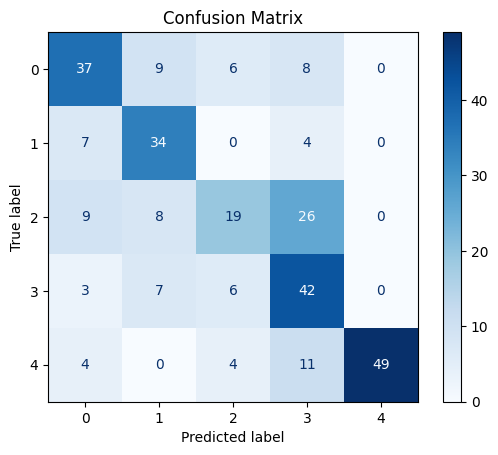

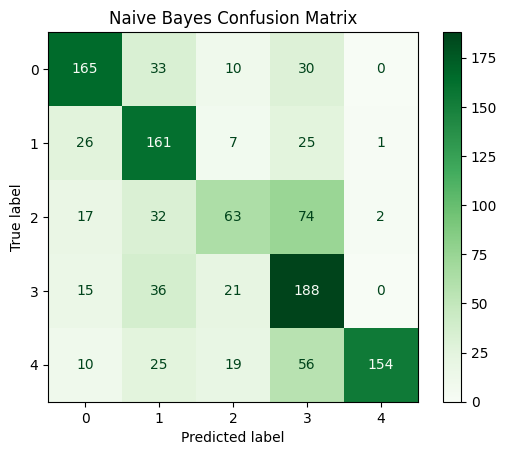

In [21]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmv =confusion_matrix(all_labels5,all_predictions5,labels=classes)
cm = confusion_matrix(y_test_5,predicted_labels_5, labels=classes)

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cmv, display_labels=classes)
disp.plot(cmap=plt.cm.Greens)
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# Four Class Classification

In [22]:
# Read dataset 
humor_4class_path = "datasets/Humour_style_4classes.xlsx" 
x_train_4, x_test_4, y_train_4, y_test_4 = read_dataset(humor_4class_path)

# Lemmmatize (Spacy)
x_train_4 = [' '.join(lemmatize_spacy(example)) for example in x_train_4]
x_test_4  = [' '.join(lemmatize_spacy(example)) for example in x_test_4]

# Convert to numpy array
x_train_4, x_test_4 = np.array(x_train_4), np.array(x_test_4)

# Cross validation
output_dir4, all_predictions4, all_labels4, all_reports4 = cross_validation("4_Classes",x_train_4,y_train_4)
aggregated_reports4 = classification_report(all_labels4,all_predictions4)
print(aggregated_reports4)

# Save Aggregated Cross Validation Results
cross_v_4= save_results(all_labels4,all_predictions4)
cross_v_4.to_csv('cross_validation_results/Naive_Bayes_4classes.csv', index=False)

Training fold 1/5
              precision    recall  f1-score   support

           0       0.85      0.39      0.54        56
           1       0.52      0.50      0.51        34
           2       0.56      0.89      0.69        98
           3       1.00      0.46      0.63        46

    accuracy                           0.63       234
   macro avg       0.73      0.56      0.59       234
weighted avg       0.71      0.63      0.61       234

Training fold 2/5
              precision    recall  f1-score   support

           0       0.79      0.50      0.61        54
           1       0.68      0.49      0.57        43
           2       0.53      0.91      0.67        79
           3       1.00      0.55      0.71        58

    accuracy                           0.65       234
   macro avg       0.75      0.61      0.64       234
weighted avg       0.73      0.65      0.65       234

Training fold 3/5
              precision    recall  f1-score   support

           0       0.

In [23]:
# Train Naive Bayes Model
log_probs_4, ex_dics_4, prob_words_4,classes = naive_bayes_multi(x_train_4,y_train_4)

# Test/Predict using Naive Bayes Model
predicted_labels_4 = predict_naive_bayes(x_test_4, log_probs_4, prob_words_4)

# Save Report
result_4= save_results(y_test_4,predicted_labels_4)
result_4.to_csv('models_results/Naive_Bayes_4classes.csv', index=False)

# Evaluation Report
print(classification_report(y_test_4,predicted_labels_4))

              precision    recall  f1-score   support

           0       0.77      0.45      0.57        60
           1       0.75      0.60      0.67        45
           2       0.65      0.94      0.77       120
           3       1.00      0.69      0.82        68

    accuracy                           0.73       293
   macro avg       0.79      0.67      0.70       293
weighted avg       0.77      0.73      0.72       293



# Two Class Classification

In [24]:
# Read dataset 
train_2class_path = "datasets/af_ag_train.xlsx" 
test_2class_path  = "datasets/af_ag_test.xlsx" 

x_train_2, x_test_2, y_train_2, y_test_2 = read_train_test_dataset(train_2class_path, test_2class_path)

# Lemmmatize (Spacy)
x_train_2 = [' '.join(lemmatize_spacy(example)) for example in x_train_2]
x_test_2  = [' '.join(lemmatize_spacy(example)) for example in x_test_2]

# Convert to numpy array
x_train_2, x_test_2 = np.array(x_train_2), np.array(x_test_2)

# Cross validation
output_dir2, all_predictions2, all_labels2, all_reports2 = cross_validation("2_Classes",x_train_2,y_train_2)
aggregated_reports2 = classification_report(all_labels2,all_predictions2)
print(aggregated_reports2)

# Save Aggregated Cross Validation Results
cross_v_2= save_results(all_labels2,all_predictions2)
cross_v_2.to_csv('cross_validation_results/Naive_Bayes_2classes.csv', index=False)


Training fold 1/5
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.69      0.82      0.75        38

    accuracy                           0.73        77
   macro avg       0.74      0.73      0.73        77
weighted avg       0.74      0.73      0.73        77

Training fold 2/5
              precision    recall  f1-score   support

           0       0.77      0.64      0.70        36
           1       0.72      0.83      0.77        41

    accuracy                           0.74        77
   macro avg       0.75      0.73      0.73        77
weighted avg       0.74      0.74      0.74        77

Training fold 3/5
              precision    recall  f1-score   support

           0       0.77      0.52      0.62        33
           1       0.71      0.89      0.79        44

    accuracy                           0.73        77
   macro avg       0.74      0.70      0.70        77
weighted avg       0

In [25]:
# Train Naive Bayes Model
log_probs_2, ex_dics_2, prob_words_2,classes = naive_bayes_multi(x_train_2,y_train_2)

# Test/Predict using Naive Bayes Model
predicted_labels_2 = predict_naive_bayes(x_test_2, log_probs_2, prob_words_2)

# Save Report
result_2= save_results(y_test_2,predicted_labels_2)
result_2.to_csv('models_results/Naive_Bayes_2classes.csv', index=False)

# Evaluation Report
print(classification_report(y_test_2,predicted_labels_2))

              precision    recall  f1-score   support

           0       0.83      0.66      0.73        44
           1       0.73      0.87      0.79        46

    accuracy                           0.77        90
   macro avg       0.78      0.76      0.76        90
weighted avg       0.78      0.77      0.76        90



# Test two model pipeline

In [27]:
pred_two_model, binary_class = two_model_pipeline(x_test_5 ,log_probs_4, log_probs_2, prob_words_4, prob_words_2)
y_test_5
# Save Report
two_model_result= save_results(y_test_5,pred_two_model)
print(two_model_result)

Length of filtered x_test: 175
              precision  recall  f1-score  support
0                 0.771   0.450     0.568     60.0
1                 0.750   0.600     0.667     45.0
2                 0.590   0.790     0.676     62.0
3                 0.522   0.828     0.640     58.0
4                 1.000   0.691     0.817     68.0
accuracy            NaN     NaN     0.676      NaN
macro avg         0.727   0.672     0.674    293.0
weighted avg      0.733   0.676     0.678    293.0


# Individual Jokes Predictions

In [ ]:
# Function
def predict_naive_bayes_single(example, log_probs, prob_words):
    # Tokenize the example
    example_tokens = tokens(example)

    # Calculate the log likelihoods for each class
    class_likelihoods = {}
    for class_label, log_prob in log_probs.items():
        class_likelihood = log_prob + sum(prob_words[class_label].get(word, 0) for word in example_tokens)
        class_likelihoods[class_label] = class_likelihood

    # Make a prediction based on the class with the highest likelihood
    prediction = max(class_likelihoods, key=class_likelihoods.get)

    return prediction


#### Example usage of Single prediction function

In [ ]:
# User input
#user_input = "I am living my best live in a cage of sadness and loneliness"
user_input = "What’s the smartest insect? A spelling bee!"

# Preprocess the user input
preprocessed_input = lemmatize_spacy(user_input)  # Replace with your actual preprocessing function
preprocessed_input = ", ".join(preprocessed_input)

# Make predictions
user_prediction_5 = predict_naive_bayes_single(preprocessed_input, log_probs_5, prob_words_5) # class model
user_prediction_4 = predict_naive_bayes_single(preprocessed_input, log_probs_4, prob_words_4) #4 class model

user_prediction_2 = "None"
if int(user_prediction_4) == 2:
    user_prediction_2 = predict_naive_bayes_single(preprocessed_input, log_probs_2, prob_words_2) #2 class model

# Print the predicted label
print(f'User Input: "{user_input}\n 5 class Model prediction : {user_prediction_5}\n 4 class Model prediction : {user_prediction_4}')
print(f' 2 class Model prediction : {user_prediction_2}; (Where 0-Affiliative, 1-Aggressive)')



User Input: "What’s the smartest insect? A spelling bee!
 5 class Model prediction : 0
 4 class Model prediction : 2
 2 class Model prediction : 0; (Where 0-Affiliative, 1-Aggressive)
